## LAB 1: Bag of Visual Words Image Classification

Team 3: Zuzana Szafranowska, Claudia Baca, Quim Comas

In [8]:
import cv2
import numpy as np
import cPickle
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier

Let us first read the train and test files

In [9]:
train_images_filenames = cPickle.load(open('train_images_filenames.dat','r'))
test_images_filenames = cPickle.load(open('test_images_filenames.dat','r'))
train_labels = cPickle.load(open('train_labels.dat','r'))
test_labels = cPickle.load(open('test_labels.dat','r'))

We create a SIFT object detector and descriptor

In [10]:
SIFTdetector = cv2.xfeatures2d.SIFT_create(nfeatures=300)

We compute the SIFT descriptors for all the train images and subsequently build a numpy array with all the descriptors stacked together

In [11]:
Train_descriptors = []
Train_label_per_descriptor = []

for filename,labels in zip(train_images_filenames,train_labels):
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    kpt,des=SIFTdetector.detectAndCompute(gray,None)
    Train_descriptors.append(des)
    Train_label_per_descriptor.append(labels)

D=np.vstack(Train_descriptors)

We now compute a k-means clustering on the descriptor space

In [12]:
k = 128
codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
codebook.fit(D)

MiniBatchKMeans(batch_size=2560, compute_labels=False, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10,
        n_clusters=128, n_init=3, random_state=42,
        reassignment_ratio=0.0001, tol=0.0, verbose=False)

And, for each train image, we project each keypoint descriptor to its closest visual word. We represent each of the images with the frequency of each visual word.

In [13]:
visual_words=np.zeros((len(Train_descriptors),k),dtype=np.float32)
for i in xrange(len(Train_descriptors)):
    words=codebook.predict(Train_descriptors[i])
    visual_words[i,:]=np.bincount(words,minlength=k)

To see the effect of K value in KNN classifier we perform a cross validation with our training set to estimate the optimal K value. Also we represent the evolution of the accuracy for each k value to see the influence of the k value:   

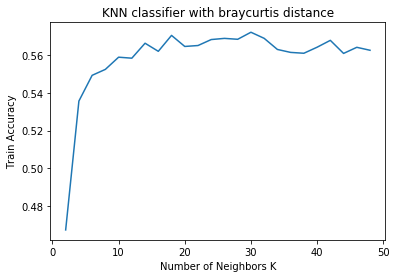

The optimal k value is 30


In [14]:
neighbors = filter(lambda x: x % 2 == 0, list(range(1,50)))
cv_scores = []

for kk in neighbors:
    knn = KNeighborsClassifier(n_neighbors=kk,n_jobs=-1,metric='braycurtis')
    scores = cross_val_score(knn, visual_words, train_labels, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

optimal_k = neighbors[cv_scores.index(max(cv_scores))]

plt.title('KNN classifier with braycurtis distance')
plt.plot(neighbors, cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Train Accuracy')
plt.show()

print "The optimal k value is %d" % optimal_k

We build a k-nn classifier and train it with the train descriptors

In [15]:
knn = KNeighborsClassifier(n_neighbors=30,n_jobs=-1,metric='braycurtis')
knn.fit(visual_words, train_labels) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='braycurtis',
           metric_params=None, n_jobs=-1, n_neighbors=30, p=2,
           weights='uniform')

We end up computing the test descriptors and compute the accuracy of the model

In [16]:
visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    kpt,des=SIFTdetector.detectAndCompute(gray,None)
    words=codebook.predict(des)
    visual_words_test[i,:]=np.bincount(words,minlength=k)

In [17]:
accuracy = 100*knn.score(visual_words_test, test_labels)
print(accuracy)

57.62081784386617


We use different distances in knn classifier  and the accuracy's results are:

With initial parameters:

- Euclidean: 53.5315
- Chebyshev: 43.2465
- Manhattan: 50.1858
- Hamming: 35.1920
- Canberra: 50.1858
- Braycurtis: 57.125

With optimal k value:

- Euclidean: 55.8859
- Chebyshev: 44.6096
- Manhattan: 52.4163
- Hamming: 37.5464
- Canberra: 51.6728
- Braycurtis: 57.6208